In [ ]:
#pip install descartes

In [ ]:
#pip install geopandas

In [27]:
import pandas 
import numpy 
import requests
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as pyplot
import math
import geopy
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [28]:
VhcH = pandas.read_csv("hubs.csv")
#Read input csv tables and create LOVID .
TripRequests = pandas.read_csv("triprequestsUPDATED.csv")

LOVID = list() #list of vehicle ids
for i in range(1, 16):
    LOVID.append("Vehicle" + str(i))

df_medicalTrips = pandas.read_csv('Medical_dataset.csv')
df_medicalTrips.rename(columns={"Longitude": "pickup_lng", "Latitude": "pickup_lat",'DropOff_Longitude': 'dropoff_lng' , 'DropOff_Latitude':'dropoff_lat'}, inplace = True)
df_medicalTrips["DPUTm"] = [i/10 for i in range(41, 152)]

In [29]:
# based on https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

from math import sin, cos, sqrt, atan2, radians

def calculateDistance(lon0, lat0, lon1, lat1):
    R = 6373.0
    
    lon0 = radians(lon0)
    lat0 = radians(lat0)
    lon1 = radians(lon1)
    lat1 = radians(lat1)
    
    dlon = lon1 - lon0
    dlat = lat1 - lat0
    
    a = sin(dlat / 2)**2 + cos(lat0) * cos(lat1) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c * 0.621371

In [30]:
class Trip:
    def __init__(self, ITID:int, ITT: str, INbORd: int,  IDTPUL:int, IWtT:int, ICT : int, ITOPULAL: tuple, ITODOLAL: tuple, IPUAd: str, IDOAd, IYMD:str, IDPUTm : int):
        self.TID = ITID #This is the Trip ID.
        self.TT = ITT # This is the TripType.
        self.NbORd = INbORd #This is the number of riders.
        self.DTPUL = IDTPUL #This is the distance to the pick up location.
        self.WtT = IWtT #This is the waiting time. 
        self.CT = ICT #This is Current Time. It can also be called the dropoff time.
        self.TOPULAL = ITOPULAL # This is a tuple of the pick up longitude and latitude.
        self.TODOLAL = ITODOLAL #This is a tuple of the drop off longitude and latitude.
        self.PUAd = IPUAd  #This is the pick up address
        self.DOAd = IDOAd  #This is the drop off address
        self.YMD = IYMD    #This is the year month and day for the pick up : the pick up timestamp
        self.DPUTm = IDPUTm  #This is the pick up time. 



In [31]:
#MDOTIDATO is make dictionary of trip ids and trip objects
#VhcH is vehicle hub. 
#NbOVhc is number of vehicles. 
#LOCTSB is list of columns to sort by.
def MDOTIDATO(TripRequests, df_medicalTrips,VhcH, LOCTSB, NbOVhc):
    LOVID = list() #list of vehicle ids
    for i in range(1, NbOVhc + 1):
        LOVID.append("Vehicle" + str(i))
    TripRequests["DPUTm"] = numpy.array([int(PuTs[11:13]) + int(PuTs[14:16])/60 for PuTs in TripRequests["scheduled_ts"]])
    #Pickup day. This is a string. 
    TripRequests["PUDy"] = numpy.array([PuTs[0:len(PuTs) - 10] for PuTs in TripRequests["scheduled_ts"]])
    TRqClb = TripRequests
    TRqClb["Fqc"] = [1 for DPUTm in TRqClb["DPUTm"] ]
    TRqClb = TRqClb.sort_values(by = ["pickup_address", "dropoff_address"])
    TRqClb = TRqClb.reset_index(drop = True)
    TRqClb["TBDlt"] = [False for DPUTm in TRqClb["DPUTm"]]
    TRqClb["City"] = [ address.split(",")[1][1:] for address in  TRqClb["pickup_address"]]
    TRqClb["State"] = [address.split(",")[2][1:3] for address in  TRqClb["pickup_address"]]
    TRqClb = TRqClb[(TRqClb["City"] == "Columbus") & (TRqClb["State"] == "OH")]
    #For the three fixed vehicle hub location.
    DOTIDATO = {}
    for index in range(1, (NbOVhc//3) + 1):
        TID = index #This is just a random irrelevant trip id. The vehicle hub is not a trip. 
        TT = "VehicleHub" #This is vehicle hub.
        NbORd = 0
        DTPUL= 0 
        WtT= 0 
        if index <= NbOVhc//7:
            CT = min(TRqClb["DPUTm"]) #Current Time
        else:
            if max(TRqClb["DPUTm"]) >= 12: 
                CT = max(TRqClb["DPUTm"]) - 12#This is current time.
            else:
                CT = 0 #This is current time. Whenever trip type is vehicle hub, it is the starting time for the vehicle.
        PuLgtALtt = (0, 0) #This is a random irrelevant pick up longitude and latitude. The vehicle hub is not a trip. 
        DoLgtALtt = (VhcH["lng"][0] , VhcH["lat"][0])
        PUAd = VhcH["hubs"][0]
        DOAd = VhcH["hubs"][0]
        YMD = "2019-12-12"
        DPUTm = 0
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    for index in range((NbOVhc//3) + 1, (2* NbOVhc//3) + 1):
        TID = index #This is just a random irrelevant trip id. The vehicle hub is not a trip. 
        TT = "VehicleHub" #This is vehicle hub.
        NbORd = 0
        DTPUL= 0
        WtT= 0  
        if index <= (NbOVhc//3) + NbOVhc//7:
            CT = min(TRqClb["DPUTm"]) #Current Time
        else:
            if max(TRqClb["DPUTm"]) >= 12: 
                CT = max(TRqClb["DPUTm"]) - 12#This is current time.
            else:
                CT = 0 #This is current time. Whenever trip type is vehicle hub, it is the starting time for the vehicle.
        PuLgtALtt = (0, 0) #This is a random irrelevant pick up longitude and latitude. The vehicle hub is not a trip. 
        DoLgtALtt = (VhcH["lng"][1] , VhcH["lat"][1])
        PUAd = VhcH["hubs"][1]
        DOAd = VhcH["hubs"][1]
        YMD = "2019-12-12"
        DPUTm = 0
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    for index in range((2* NbOVhc//3) + 1, NbOVhc + 1):
        TID = index #This is just a random irrelevant trip id. The vehicle hub is not a trip. 
        TT = "VehicleHub" #This is vehicle hub.
        NbORd = 0
        DTPUL= 0  
        WtT= 0
        if index <= (2* NbOVhc//3) + NbOVhc//7:
            CT = min(TRqClb["DPUTm"]) #Current Time
        else:
            if max(TRqClb["DPUTm"]) >= 12: 
                CT = max(TRqClb["DPUTm"]) - 12#This is current time.
            else:
                CT = 0 #This is current time. Whenever trip type is vehicle hub, it is the starting time for the vehicle.
        PuLgtALtt = (0, 0) #This is a random irrelevant pick up longitude and latitude. The vehicle hub is not a trip. 
        DoLgtALtt = (VhcH["lng"][2] , VhcH["lat"][2])
        PUAd = VhcH["hubs"][2]
        DOAd = VhcH["hubs"][2]
        YMD = "2019-12-12"
        DPUTm = 0
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    TRqClb = TRqClb.sort_values(by = ["pickup_address", "dropoff_address", "DPUTm"])
    LOTb = len(TRqClb["Fqc"])
    for i in range(1, LOTb):
        if TRqClb.iloc[i, 4] == TRqClb.iloc[i - 1, 4] and TRqClb.iloc[i, 6] == TRqClb.iloc[i - 1, 6] and TRqClb.iloc[i, 24] - TRqClb.iloc[i -1 , 24] ==0 and TRqClb.iloc[i - 1, 26] != 5 :
            TRqClb.iloc[i, 26] = TRqClb.iloc[i - 1, 26] + 1
            TRqClb.iloc[i - 1, 27] = True
    TRqClb = TRqClb[TRqClb["TBDlt"] == False]
    MdcTClb = df_medicalTrips[(df_medicalTrips["City"] == "Columbus") & (df_medicalTrips["State"] == "OH")]
    MdcTClb = MdcTClb.sort_values(by = LOCTSB)
    for index, entry in MdcTClb.iterrows():
        TID = entry['trip_id'] 
        TT = "Medicine" 
        NbORd = 0
        DTPUL= 0 
        WtT= 0
        CT = 12
        PuLgtALtt = (entry["pickup_lng"], entry['pickup_lat'])
        DoLgtALtt = (entry['dropoff_lng'], entry['dropoff_lat'])
        PUAd = entry["Street"]
        DOAd = entry["Street"]
        YMD =  "2019-12-12"
        DPUTm = entry["DPUTm"]
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    TRqClb = TRqClb.sort_values(by = LOCTSB)
    for index, entry in TRqClb.iterrows():
        TID = entry['id'] 
        TT = "People" 
        NbORd = entry["Fqc"]
        DTPUL= 0  
        WtT= 0
        CT = entry["DPUTm"]
        PuLgtALtt = (entry["pickup_lng"], entry['pickup_lat'])
        DoLgtALtt = (entry['dropoff_lng'], entry['dropoff_lat'])
        PUAd = entry["pickup_address"]
        DOAd = entry["dropoff_address"]
        YMD =  entry["scheduled_ts"]
        DPUTm = entry["DPUTm"]
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    return [DOTIDATO, min(TRqClb["DPUTm"])]

    
        
        
    

In [32]:
DOTIDATO = MDOTIDATO(TripRequests,df_medicalTrips, VhcH,["pickup_lng", 'pickup_lat'], 15)[0]

In [33]:
CODOTIDATO = dict(DOTIDATO)
DOTIDATO = dict(CODOTIDATO)
#To see how the useful information in DOTIDATO 
AVLOLOUTOA = [] #This is all vehicles' list of list(s) of useful trip object attributes.
for TID in DOTIDATO.keys():
    TOj = DOTIDATO[TID]
    LOLOUTOA = [TID, TOj.TT, TOj.NbORd, TOj.DTPUL, TOj.CT, TOj.PUAd, TOj.DOAd, TOj.YMD, TOj.DPUTm]
    AVLOLOUTOA.append(LOLOUTOA)
#Distance simple model table
TOTIDAUTO = pandas.DataFrame(AVLOLOUTOA, columns = ["TripID", "TripType", "Number Of People", "Distance to Pickup", "Current Time", "Pickup Address", "Dropoff Address", "Date", "Pickup time" ])


In [34]:
#DtSpMd is distance simple model.
#DOTIDATO is dictionary of trip ids and trip objects. 
#NbOVhc is number of vehicles.
def DtSpMd(DOTIDATO, NbOVhc):
    LOVID = list() #list of vehicle ids
    for i in range(1, NbOVhc + 1):
        LOVID.append("Vehicle" + str(i))
    DOTIDATO = dict(CODOTIDATO)
    #The code below considers just the distance between each vehicle and the pickup address of the trip that needs to be assigned to a vehicle. 
    ATID = list(DOTIDATO.keys()) #All trip IDs in DOTIDATO
    DOVIDALOTO = {}  # Dictionary of vehicle IDs and least of trip objects.
    # Assign initial vehicle positions (vehicle hubs). Initial vehicle positions must also be converted to trip objects. 
    
    for i, VID in enumerate(LOVID):
        DOVIDALOTO[VID] = [DOTIDATO[ATID[i]]]
        DOTIDATO.pop(ATID[i])
    ATID = list(DOTIDATO.keys()) #All trip IDs in DOTIDATO
    for TID in ATID:
        CTO =  DOTIDATO[TID]  #Current trip object that neeeds to be assigned.
        DOVIDAD = {}  #Dictionary of vehicle IDs and distances.
        for VID in LOVID:
            LOTO = DOVIDALOTO[VID]  #List of trip object for this VID
            LTO = LOTO[len(LOTO) - 1] #Last trip object in the list of trip objects
            DOVIDAD[VID] = calculateDistance(LTO.TODOLAL[0], LTO.TODOLAL[1], CTO.TOPULAL[0], CTO.TOPULAL[1])
        VIDWMD = min(DOVIDAD, key = DOVIDAD.get) #Vehicle ID with minimum distance to current trip object pick up address.
        CTO.DTPUL = DOVIDAD[VIDWMD]
        DOVIDALOTO[VIDWMD].append(CTO)
    #Extract useful information from the trip objects in the dictionary of vehicle id and list of trip objects. 
    AVLOLOUTOA = [] #This is all vehicles' list of list(s) of useful trip object attributes.
    for VID in DOVIDALOTO.keys():
        LOLOUTOA = list(DOVIDALOTO[VID]) #This is list of list(s) of useful trip object attributes. 
        for i in range(len(LOLOUTOA)):
            LOLOUTOA[i] = [VID, LOLOUTOA[i].TID, LOLOUTOA[i].TT, LOLOUTOA[i].NbORd, LOLOUTOA[i].DTPUL, LOLOUTOA[i].CT, LOLOUTOA[i].PUAd, LOLOUTOA[i].DOAd,LOLOUTOA[i].DPUTm ]
        AVLOLOUTOA = AVLOLOUTOA + LOLOUTOA
    #Distance and time simple model table
    DtSpMdTb = pandas.DataFrame(AVLOLOUTOA, columns = ["VehicleID", "TripID", "TripType", "Number Of Riders", "Distance to Pickup", "Current Time", "Pickup Address", "Dropoff Address", "Pickup Time" ])
    return DtSpMdTb


In [35]:
DOTIDATO = MDOTIDATO(TripRequests,df_medicalTrips, VhcH,["pickup_lng", 'pickup_lat'], 15)[0]
DtSpMdTb = DtSpMd(DOTIDATO, 15)

In [36]:
DtSpMdTb["VehicleID"].unique()

array(['Vehicle1', 'Vehicle2', 'Vehicle3', 'Vehicle4', 'Vehicle5',
       'Vehicle6', 'Vehicle7', 'Vehicle8', 'Vehicle9', 'Vehicle10',
       'Vehicle11', 'Vehicle12', 'Vehicle13', 'Vehicle14', 'Vehicle15'],
      dtype=object)

In [37]:
#The average distance travelled to pick up riders and or medicine packages. 
numpy.mean(DtSpMdTb[(DtSpMdTb["VehicleID"] != "UnassignedTrips") & (DtSpMdTb["TripType"] != "VehicleHub")]["Distance to Pickup"])

1.1100105262232804

Assumptions used in the model.
All the people and medicine trips that occur in the city of Columbus, Ohio have to be fulfilled in one day (to makes sure the model has enough data points). 
The length of a driver's shift is 12 hours. 
There are 15 honda vehicles each with 7 passenger seats (at most, only 5 of those seats will be used to avoid overcrowding). The speed used is 25 miles/hr.
The cars will be cleaned during the waiting time to address covid concerns, especially when the driver has to wait a bit before picking up the next rider or medicine package. 
The goal of the model is to minimize the average of distance to pickup, the average of the driver's waiting time for the next pickup and the number of unassigned trips. 

In [38]:
 
#DOTIDATO is dictionary of trip ids and trip objects. 
#EDPUTm is the earliest desired pick up time.
#NbOVhc is number of vehicles.
#DtATSpMd is distance and time simple model.
def DtATSpMd(DOTIDATO, EDPUTm, NbOVhc,):
    LOVID = list() #list of vehicle ids
    for i in range(1, NbOVhc + 1):
        LOVID.append("Vehicle" + str(i))
    ATID = list(DOTIDATO.keys())
    DOVIDALOTO = {}  # Dictionary of vehicle ID's and list of trip objects
    # Assign initial vehicle locations (vehicle hubs). 
    #Initial vehicle locations must also be converted to trip objects. 
    for i, VID in enumerate(LOVID):
        DOVIDALOTO[VID] = [DOTIDATO[ATID[i]]]
        DOTIDATO.pop(ATID[i])
    ATID = list(DOTIDATO.keys())
    for TID in ATID:
        CTO =  DOTIDATO[TID]
        #Dictionary of the distance from each vehicle to the pick up uaddress of this current trip.
        DOVIDAD = {}
        for VID in LOVID:
            LOTO = DOVIDALOTO[VID]
            LTO = LOTO[len(LOTO) - 1]
            #((CTO.DPUTm - LTO.CT) * 7.5) is the penalty for the driver's waiting time. 
            if len(LOTO) == 1:
                DOVIDAD[VID] = calculateDistance(LTO.TODOLAL[0], LTO.TODOLAL[1], CTO.TOPULAL[0], CTO.TOPULAL[1])
            else:
                DOVIDAD[VID] = calculateDistance(LTO.TODOLAL[0], LTO.TODOLAL[1], CTO.TOPULAL[0], CTO.TOPULAL[1]) + ((CTO.DPUTm - LTO.CT) * 7.5) 
        while len(DOVIDAD) > 0:
            VIDWMD = min(DOVIDAD, key = DOVIDAD.get)
            LOTO = DOVIDALOTO[VIDWMD]
            FTO = LOTO[0] #First trip object
            LTO = LOTO[len(LOTO) - 1] #Last trip object
            
            if len(LOTO) == 1:
                TD = DOVIDAD[VIDWMD] + calculateDistance(CTO.TOPULAL[0], CTO.TOPULAL[1], CTO.TODOLAL[0], CTO.TODOLAL[1]) 
                TITTPU = DOVIDAD[VIDWMD]/25
                TITTDO = calculateDistance(CTO.TOPULAL[0], CTO.TOPULAL[1], CTO.TODOLAL[0], CTO.TODOLAL[1])/25
                TITTCT = TD/25
                if CTO.DPUTm - FTO.CT  <= 12: #Use a limit of 12 hrs.
                #1 is the earliest pickup time.
                    if CTO.DPUTm >= LTO.CT + TITTPU or CTO.DPUTm == EDPUTm:  
                        CTO.DTPUL =  DOVIDAD[VIDWMD]
                        CTO.WtT = CTO.DPUTm - TITTPU - LTO.CT
                        #The minimum recommendation by CDC is to clean the vehicle at the beginning and end of the day. 
                        #The drivers can rest and clean the car in situations where they have to wait for some time before being able to pick up the next rider. 
                        CTO.CT = CTO.DPUTm + TITTDO 
                        DOVIDALOTO[VIDWMD].append(CTO)
                        if CTO == DOVIDALOTO[VIDWMD][1]:
                            FTO.CT = CTO.DPUTm
                            DOVIDALOTO[VIDWMD][1].WtT = 0
                        DOTIDATO.pop(TID)
                        DOVIDAD = {}
                    else:
                        DOVIDAD.pop(VIDWMD) 
                else:
                    DOVIDAD.pop(VIDWMD)
            else:
                #TD is Total distance: the Distance from the current location of the vechicle closest to the pickup address to the drop off address of the trip.
                TD = DOVIDAD[VIDWMD] - ((CTO.DPUTm - LTO.CT) * 7.5) + calculateDistance(CTO.TOPULAL[0], CTO.TOPULAL[1], CTO.TODOLAL[0], CTO.TODOLAL[1]) 
                #TITTPU is the time it takes to pick up the rider. 
                TITTPU = (DOVIDAD[VIDWMD] - ((CTO.DPUTm - LTO.CT) * 7.5))/25
                #TITTDO is the time it takes to drop the rider. 
                TITTDO = calculateDistance(CTO.TOPULAL[0], CTO.TOPULAL[1], CTO.TODOLAL[0], CTO.TODOLAL[1])/25
                #TITTCT it the time it takes to complete trip. 
                TITTCT = TD/25
                if CTO.DPUTm - FTO.CT  <= 12: #Use a limit of 12 hrs.
                    #1 is the earliest pickup time.
                    if CTO.DPUTm >= LTO.CT + TITTPU or CTO.DPUTm == EDPUTm:  
                        CTO.DTPUL =  DOVIDAD[VIDWMD] - ((CTO.DPUTm - LTO.CT) * 7.5)
                        CTO.WtT = CTO.DPUTm - TITTPU - LTO.CT
                        #The minimum recommendation by CDC is to clean the vehicle at the beginning and end of the day. 
                        #The drivers can rest and clean the car in situations where they have to wait for some time before being able to pick up the next rider. 
                        CTO.CT = CTO.DPUTm + TITTDO 
                        DOVIDALOTO[VIDWMD].append(CTO)
                        if CTO == DOVIDALOTO[VIDWMD][1]:
                            FTO.CT = CTO.DPUTm
                            DOVIDALOTO[VIDWMD][1].WtT = 0
                        DOTIDATO.pop(TID)
                        DOVIDAD = {}
                    else:
                        DOVIDAD.pop(VIDWMD) 
                else:
                    DOVIDAD.pop(VIDWMD)
    DOVIDALOTO["UnassignedTrips"]  = DOTIDATO.values()
    #Extract useful information from the trip objects in the dictionary of vehicle id and list of trip objects. 
    AVLOLOUTOA = [] #This is all vehicles' list of list(s) of useful trip object attributes.
    for VID in DOVIDALOTO.keys():
        LOLOUTOA = list(DOVIDALOTO[VID]) #This is list of list(s) of useful trip object attributes. 
        for i in range(len(LOLOUTOA)):
            LOLOUTOA[i] = [VID, LOLOUTOA[i].TID, LOLOUTOA[i].TT, LOLOUTOA[i].NbORd, LOLOUTOA[i].DTPUL, LOLOUTOA[i].WtT, LOLOUTOA[i].CT, LOLOUTOA[i].PUAd, LOLOUTOA[i].DOAd,LOLOUTOA[i].DPUTm ]
        AVLOLOUTOA = AVLOLOUTOA + LOLOUTOA
    #DtATSpMdTb is Distance and time simple model table
    DtATSpMdTb = pandas.DataFrame(AVLOLOUTOA, columns = ["VehicleID", "TripID", "TripType", "Number Of Riders", "Distance to Pickup", "Waiting Time", "Dropoff Time", "Pickup Address", "Dropoff Address", "Desired Pickup Time" ])
    return DtATSpMdTb




  






  

In [39]:
#This is an example for number of vehicles equal to 15.
#RtL is returned list.
RtL = MDOTIDATO(TripRequests,df_medicalTrips, VhcH,["DPUTm"], 15)
DOTIDATO = RtL[0]
EDPUTm = RtL[1]
DtATSpMdTb = DtATSpMd(DOTIDATO, EDPUTm,  15)



In [47]:
DtATSpMdTb.iloc[80:84, :]

,VehicleID,TripID,TripType,Number Of Riders,Distance to Pickup,Waiting Time,Dropoff Time,Pickup Address,Dropoff Address,Desired Pickup Time
80,Vehicle4,4,VehicleHub,0,0.000000,0.000000,11.833333,"3265 E 5th Ave., Columbus Ohio","3265 E 5th Ave., Columbus Ohio",0.000000
81,Vehicle4,328866,People,5,1.973100,0.000000,12.381114,"4495 East Broad Street, Columbus, OH, USA","3780 Tradeport Ct, Lockbourne, OH 43137, USA",11.833333
82,Vehicle4,406648,People,5,7.448355,0.737619,13.666966,"397 Harland Drive, Columbus, OH, USA","348 S Cassingham Rd, Columbus, OH 43209, USA",13.416667
83,Vehicle4,324118,People,5,5.561160,0.610588,15.072065,"300 Dana Avenue, Columbus, OH, USA","6220 E Dublin Granville Rd, New Albany, OH 430...",14.500000


In [48]:
DOPM  = {}
#The average distance travelled to pick up riders and medicine packages. 
DOPM["Average Distance to Pickup"] = numpy.mean(DtATSpMdTb[(DtATSpMdTb["VehicleID"] != "UnassignedTrips") & (DtATSpMdTb["TripType"] != "VehicleHub")]["Distance to Pickup"])
#The average waiting time
DOPM["Average Waiting Time"] = numpy.mean(DtATSpMdTb[(DtATSpMdTb["VehicleID"] != "UnassignedTrips") & (DtATSpMdTb["TripType"] != "VehicleHub")]["Waiting Time"])
#The number of assigned trips.
DOPM["Number Of Assigned Trips"] = len(DtATSpMdTb[(DtATSpMdTb["VehicleID"] != "UnassignedTrips") & (DtATSpMdTb["TripType"] != "VehicleHub")])
#The number of unassigned trips.
DOPM["Number of Unassigned Trips"] = len(DtATSpMdTb[DtATSpMdTb["VehicleID"] == "UnassignedTrips"])
DOPM

{'Average Distance to Pickup': 1.360891635566831,
 'Average Waiting Time': 0.2384061311878465,
 'Number Of Assigned Trips': 472,
 'Number of Unassigned Trips': 170}

In [49]:
DtATSpMdTb["VehicleID"].value_counts()

UnassignedTrips    170
Vehicle4            55
Vehicle8            51
Vehicle3            44
Vehicle11           41
Vehicle12           40
Vehicle5            38
Vehicle9            36
Vehicle10           33
Vehicle15           32
Vehicle13           29
Vehicle14           28
Vehicle1            26
Vehicle6            14
Vehicle7            10
Vehicle2            10
Name: VehicleID, dtype: int64

In [50]:
#DONOVAPM is dictionary of number of vehicles and performance metrics.
DONOVAPM = {}
for NbOVhc in [9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51]:
    RtVl = MDOTIDATO(TripRequests,df_medicalTrips, VhcH,["DPUTm"], NbOVhc)
    DOTIDATO = RtVl[0]
    EDPUTm = RtVl[1]
    DtATSpMdTb = DtATSpMd(DOTIDATO, EDPUTm,  NbOVhc)
    LOPM  = []
    LOPM.append(numpy.mean(DtATSpMdTb[(DtATSpMdTb["VehicleID"] != "UnassignedTrips") & (DtATSpMdTb["TripType"] != "VehicleHub")]["Distance to Pickup"]))
    LOPM.append(numpy.mean(DtATSpMdTb[(DtATSpMdTb["VehicleID"] != "UnassignedTrips") & (DtATSpMdTb["TripType"] != "VehicleHub")]["Waiting Time"]))
    LOPM.append(len(DtATSpMdTb[(DtATSpMdTb["VehicleID"] != "UnassignedTrips") & (DtATSpMdTb["TripType"] != "VehicleHub")]))
    LOPM.append(len(DtATSpMdTb[DtATSpMdTb["VehicleID"] == "UnassignedTrips"]))
    DONOVAPM[NbOVhc] = LOPM


In [51]:
#ANOVLOLOPM is all number of vehicles' list of list(s) of performance metrics.
ANOVLOLOPM = []
for NbOVhc in DONOVAPM.keys():
    ANOVLOLOPM.append([NbOVhc] + list(DONOVAPM[NbOVhc]))
    #This is table of number of vehicles and performance metrics.
    TONOVAPM = pandas.DataFrame(ANOVLOLOPM, columns = ["Number Of Vehicles", "Average Distance to Pickup", "Average Waiting Time", "Number Of Assigned Trips", "Number of Unassigned Trips"])
    

In [52]:
TONOVAPM.iloc[0:20, :]

,Number Of Vehicles,Average Distance to Pickup,Average Waiting Time,Number Of Assigned Trips,Number of Unassigned Trips
0,9,1.283042,0.178697,350,292
1,12,1.372455,0.195457,422,220
2,15,1.360892,0.238406,472,170
3,18,1.357322,0.276802,504,138
4,21,1.277000,0.313396,555,87
5,24,1.252840,0.349051,580,62
6,27,1.302113,0.395757,586,56
7,30,1.270313,0.440640,610,32
8,33,1.271791,0.434159,612,30
9,36,1.250933,0.433517,636,6


In [20]:
#To see how the distance-only simple model works for the medicine dataset, run the cells below. 

In [53]:
def DtSpMdFMT(DOTIDATO, NbOVhc):
    LOVID = list() #list of vehicle ids
    for i in range(1, NbOVhc + 1):
        LOVID.append("Vehicle" + str(i))
    #The code below considers just the distance between each vehicle and the pickup address of the trip that needs to be assigned to a vehicle. 
    ATID = list(DOTIDATO.keys()) #All trip IDs in DOTIDATO
    DOVIDALOTO = {}  # Dictionary of vehicle IDs and least of trip objects.
    # Assign initial vehicle positions (vehicle hubs). Initial vehicle positions must also be converted to trip objects. 
    
    for i, VID in enumerate(LOVID):
        DOVIDALOTO[VID] = [DOTIDATO[ATID[i]]]
        DOTIDATO.pop(ATID[i])
    ATID = list(DOTIDATO.keys()) #All trip IDs in DOTIDATO
    for TID in ATID:
        CTO =  DOTIDATO[TID]  #Current trip object that neeeds to be assigned.
        DOVIDAD = {}  #Dictionary of vehicle IDs and distances.
        for VID in LOVID:
            LOTO = DOVIDALOTO[VID]  #List of trip object for this VID
            LTO = LOTO[len(LOTO) - 1] #Last trip object in the list of trip objects
            DOVIDAD[VID] = calculateDistance(LTO.TODOLAL[0], LTO.TODOLAL[1], CTO.TOPULAL[0], CTO.TOPULAL[1])
        VIDWMD = min(DOVIDAD, key = DOVIDAD.get) #Vehicle ID with minimum distance to current trip object pick up address.
        CTO.DTPUL = DOVIDAD[VIDWMD]
        DOVIDALOTO[VIDWMD].append(CTO)
    return DOVIDALOTO

In [54]:
#This is make dictionary of trip ids and trip objects for medicine trips.
#VhcH is vehicle hub. 
#NbOVhc is number of vehicles. 
def MDOTIDATOFMT(TripRequests, df_medicalTrips,VhcH, NbOVhc):
    LOVID = list() #list of vehicle ids
    for i in range(1, NbOVhc + 1):
        LOVID.append("Vehicle" + str(i))
    TripRequests["DPUTm"] = numpy.array([int(PuTs[11:13]) + int(PuTs[14:16])/60 for PuTs in TripRequests["scheduled_ts"]])
    #Pickup day. This is a string. 
    TripRequests["PUDy"] = numpy.array([PuTs[0:len(PuTs) - 10] for PuTs in TripRequests["scheduled_ts"]])
    TRqClb = TripRequests
    TRqClb["Fqc"] = [1 for DPUTm in TRqClb["DPUTm"] ]
    TRqClb = TRqClb.sort_values(by = ["pickup_address", "dropoff_address"])
    TRqClb = TRqClb.reset_index(drop = True)
    TRqClb["TBDlt"] = [False for DPUTm in TRqClb["DPUTm"]]
    TRqClb["City"] = [ address.split(",")[1][1:] for address in  TRqClb["pickup_address"]]
    TRqClb["State"] = [address.split(",")[2][1:3] for address in  TRqClb["pickup_address"]]
    TRqClb = TRqClb[(TRqClb["City"] == "Columbus") & (TRqClb["State"] == "OH")]
    #For the three fixed vehicle hub location.
    DOTIDATO = {}
    for index in range(1, (NbOVhc//3) + 1):
        TID = index #This is just a random irrelevant trip id. The vehicle hub is not a trip. 
        TT = "VehicleHub" #This is vehicle hub.
        NbORd = 0
        DTPUL= 0 
        WtT= 0 
        if index <= NbOVhc//7:
            CT = min(TRqClb["DPUTm"]) #Current Time
        else:
            if max(TRqClb["DPUTm"]) >= 12: 
                CT = max(TRqClb["DPUTm"]) - 12#This is current time.
            else:
                CT = 0 #This is current time. Whenever trip type is vehicle hub, it is the starting time for the vehicle.
        PuLgtALtt = (0, 0) #This is a random irrelevant pick up longitude and latitude. The vehicle hub is not a trip. 
        DoLgtALtt = (VhcH["lng"][0] , VhcH["lat"][0])
        PUAd = VhcH["hubs"][0]
        DOAd = VhcH["hubs"][0]
        YMD = "2019-12-12"
        DPUTm = 0
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    for index in range((NbOVhc//3) + 1, (2* NbOVhc//3) + 1):
        TID = index #This is just a random irrelevant trip id. The vehicle hub is not a trip. 
        TT = "VehicleHub" #This is vehicle hub.
        NbORd = 0
        DTPUL= 0
        WtT= 0  
        if index <= (NbOVhc//3) + NbOVhc//7:
            CT = min(TRqClb["DPUTm"]) #Current Time
        else:
            if max(TRqClb["DPUTm"]) >= 12: 
                CT = max(TRqClb["DPUTm"]) - 12#This is current time.
            else:
                CT = 0 #This is current time. Whenever trip type is vehicle hub, it is the starting time for the vehicle.
        PuLgtALtt = (0, 0) #This is a random irrelevant pick up longitude and latitude. The vehicle hub is not a trip. 
        DoLgtALtt = (VhcH["lng"][1] , VhcH["lat"][1])
        PUAd = VhcH["hubs"][1]
        DOAd = VhcH["hubs"][1]
        YMD = "2019-12-12"
        DPUTm = 0
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    for index in range((2* NbOVhc//3) + 1, NbOVhc + 1):
        TID = index #This is just a random irrelevant trip id. The vehicle hub is not a trip. 
        TT = "VehicleHub" #This is vehicle hub.
        NbORd = 0
        DTPUL= 0  
        WtT= 0
        if index <= (2* NbOVhc//3) + NbOVhc//7:
            CT = min(TRqClb["DPUTm"]) #Current Time
        else:
            if max(TRqClb["DPUTm"]) >= 12: 
                CT = max(TRqClb["DPUTm"]) - 12#This is current time.
            else:
                CT = 0 #This is current time. Whenever trip type is vehicle hub, it is the starting time for the vehicle.
        PuLgtALtt = (0, 0) #This is a random irrelevant pick up longitude and latitude. The vehicle hub is not a trip. 
        DoLgtALtt = (VhcH["lng"][2] , VhcH["lat"][2])
        PUAd = VhcH["hubs"][2]
        DOAd = VhcH["hubs"][2]
        YMD = "2019-12-12"
        DPUTm = 0
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    MdcTClb = df_medicalTrips
    MdcTClb = MdcTClb.sort_values(by = ["pickup_lng", 'pickup_lat'])
    for index, entry in MdcTClb.iterrows():
        TID = entry['trip_id'] 
        TT = "Medicine" 
        NbORd = 0
        DTPUL= 0 
        WtT= 0
        CT = 12
        PuLgtALtt = (entry["pickup_lng"], entry['pickup_lat'])
        DoLgtALtt = (entry['dropoff_lng'], entry['dropoff_lat'])
        PUAd = entry["Street"]
        DOAd = entry["Street"]
        YMD =  "2019-12-12"
        DPUTm = entry["DPUTm"]
        TOj = Trip(TID, TT, NbORd, DTPUL, WtT, CT, PuLgtALtt, DoLgtALtt, PUAd, DOAd, YMD, DPUTm)
        DOTIDATO [TID] = TOj
    return DOTIDATO

In [55]:
VhcH = pandas.read_csv("hubs.csv")
#Read input csv tables and create LOVID .
TripRequests = pandas.read_csv("triprequestsUPDATED.csv")

LOVID = list() #list of vehicle ids
for i in range(1, 16):
    LOVID.append("Vehicle" + str(i))

df_medicalTrips = pandas.read_csv('Medical_dataset.csv')
df_medicalTrips.rename(columns={"Longitude": "pickup_lng", "Latitude": "pickup_lat",'DropOff_Longitude': 'dropoff_lng' , 'DropOff_Latitude':'dropoff_lat'}, inplace = True)
df_medicalTrips["DPUTm"] = [i/10 for i in range(41, 152)]
DOTIDATO = MDOTIDATOFMT(TripRequests, df_medicalTrips, VhcH, 15) 
DOVIDALOTO = DtSpMdFMT(DOTIDATO, 15)
#Extract useful information from the trip objects in the dictionary of vehicle id and list of trip objects. 
AVLOLOUTOA = [] #This is all vehicles' list of list(s) of useful trip object attributes.
for VID in DOVIDALOTO.keys():
    LOLOUTOA = list(DOVIDALOTO[VID]) #This is list of list(s) of useful trip object attributes. 
    for i in range(len(LOLOUTOA)):
        LOLOUTOA[i] = [VID, LOLOUTOA[i].TID, LOLOUTOA[i].TT, LOLOUTOA[i].NbORd, LOLOUTOA[i].DTPUL, LOLOUTOA[i].CT, LOLOUTOA[i].PUAd, LOLOUTOA[i].DOAd,LOLOUTOA[i].DPUTm, LOLOUTOA[i].TOPULAL[0], LOLOUTOA[i].TOPULAL[1], LOLOUTOA[i].TODOLAL[0], LOLOUTOA[i].TODOLAL[1]]
    AVLOLOUTOA = AVLOLOUTOA + LOLOUTOA
        
#Distance and time simple model table
DtSpMdTb = pandas.DataFrame(AVLOLOUTOA, columns = ["VehicleID", "TripID", "TripType", "Number Of Riders", "Distance to Pickup", "Current Time", "Pickup Address", "Dropoff Address", "Pickup Time", "PULgt", "PULtt" , "DOLgt" , "DOLtt"  ])

In [56]:
#The average distance travelled to pick up riders and medicine packages. 
numpy.mean(DtSpMdTb[(DtSpMdTb["VehicleID"] != "UnassignedTrips") & (DtSpMdTb["TripType"] != "VehicleHub")]["Distance to Pickup"])


5.267282383720545

In [57]:
DtSpMdTb["VehicleID"].value_counts()

Vehicle12    88
Vehicle7     12
Vehicle11     5
Vehicle1      4
Vehicle8      3
Vehicle6      2
Vehicle15     2
Vehicle13     2
Vehicle14     2
Vehicle10     1
Vehicle5      1
Vehicle2      1
Vehicle4      1
Vehicle9      1
Vehicle3      1
Name: VehicleID, dtype: int64

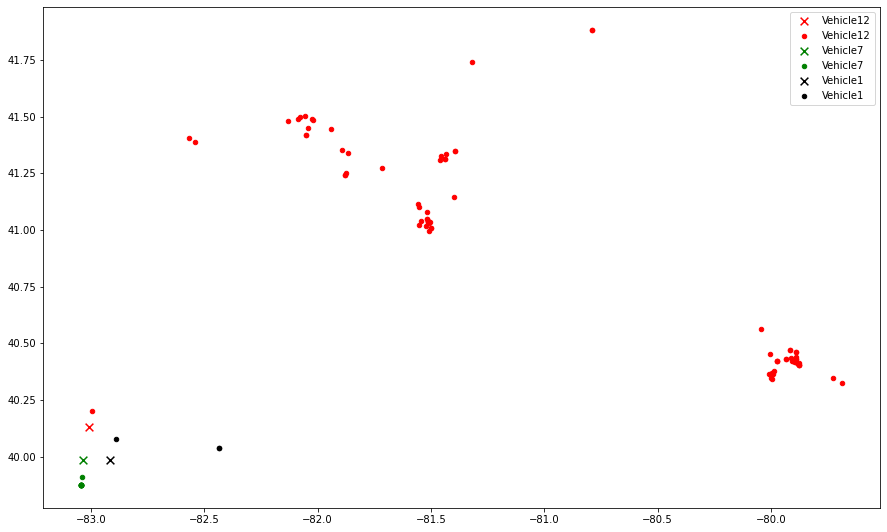

In [58]:
fig, ax = pyplot.subplots(figsize=(15, 15))

Gmt1 = [Point(xy) for xy in zip(DtSpMdTb["DOLgt"], DtSpMdTb["DOLtt"])]
GDtf1 = GeoDataFrame(DtSpMdTb, geometry=Gmt1) 

#In this model, there are only three vehicle hubs. 

GDtf1[(GDtf1["VehicleID"] == "Vehicle12") & (GDtf1["TripType"] == "VehicleHub")].plot(ax = ax, markersize = 60, color = "red", marker = "x", label = "Vehicle12")
GDtf1[(GDtf1["VehicleID"] == "Vehicle12") & (GDtf1["TripType"] != "VehicleHub")].plot(ax = ax, markersize = 20, color = "red", marker = "o", label = "Vehicle12")
GDtf1[(GDtf1["VehicleID"] == "Vehicle7") & (GDtf1["TripType"] == "VehicleHub")].plot(ax = ax, markersize = 60, color = "green", marker = "x", label = "Vehicle7")
GDtf1[(GDtf1["VehicleID"] == "Vehicle7") & (GDtf1["TripType"] != "VehicleHub")].plot(ax = ax, markersize = 20, color = "green", marker = "o", label = "Vehicle7")
GDtf1[(GDtf1["VehicleID"] == "Vehicle1") & (GDtf1["TripType"] == "VehicleHub")].plot(ax = ax, markersize = 60, color = "black", marker = "x", label = "Vehicle1")
GDtf1[(GDtf1["VehicleID"] == "Vehicle1") & (GDtf1["TripType"] != "VehicleHub")].plot(ax = ax, markersize = 20, color = "black", marker = "o", label = "Vehicle1")



                                          
pyplot.legend(prop = {"size" : 10})

 
